In [ ]:
#INSTALL DEEP INVERSE
%%capture
!pip install git+https://github.com/deepinv/deepinv.git

In [ ]:
# IMPORT LIBRARY
import deepinv as dinv
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from torchvision import transforms, datasets

from deepinv.models import DnCNN

In [ ]:
# SET RANDOM SEED FROM PYTORCH: to ensure reproducibility of the example.
torch.manual_seed(42)

# SET DEVICE: to use GPU on colab, first change the runtime to T4 GPU
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

# Use parallel dataloader if using a GPU to fasten training.
num_workers = 5 if torch.cuda.is_available() else 0

Selected GPU 0 with 15092 MiB free memory 


#STEP 1: UPLOAD DATASET BLUR OF THE PB

In [ ]:
# UPLOAD DATASET OF MODEL
blurred_data_path = 'blur/deblur0.h5'

#TRAIN DATASET
blur_train_dataset = dinv.datasets.HDF5Dataset(path=blurred_data_path, train=True)
#TEST DATASET
blur_test_dataset = dinv.datasets.HDF5Dataset(path=blurred_data_path, train=False)


# STEP 2: DEFINE PHYSICS OF MODEL

In [ ]:
# DEFINE FILTER : Gaussian Blur
filter = dinv.physics.blur.gaussian_blur(sigma=(2, 0.1), angle=45.0).to(device=device)

# DEFINE NOISE: Gaussian Noise
noise_model = dinv.physics.GaussianNoise(sigma=0.1)

# DEFINE PHYSICS: BlurFFT
blur_physics = dinv.physics.BlurFFT(filter=filter,img_size=(1, 28, 28),device=device,noise_model=noise_model)

# STEP 3: UNFOLDED MODEL

In [ ]:
#1. DATA FIDELITY L2
data_fidelity = dinv.optim.data_fidelity.L2()

#2. SELECT AN EMPTY DENOISER DnCNN
#     pretrained=None: the Neural Network is not pretrained
denoiser = dinv.models.DnCNN(in_channels=1, out_channels=1,depth=7, pretrained=None).to(device)

#3. DEFINE PRIOR PnP + EMPTY DENOISER
priorUnr = dinv.optim.PnP(denoiser)

#4. DEFINE UNFOLDED MODEL
modelUnr = dinv.unfolded.unfolded_builder(
    iteration="PGD",
    data_fidelity=data_fidelity,
    prior=priorUnr,
    params_algo={"stepsize": 1.0, "g_param": 1.0},
    trainable_params=["stepsize", "g_param"],
    device=device
)

#STEP 4: SPLIT DATASET IN TEST AND TRAINING

In [ ]:
# Set the dataloader for the training
batch_size=10
#TRAIN
train_dataloader = DataLoader(blur_train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
#TEST
test_dataloader = DataLoader(blur_test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# STEP 5: TRAIN THE MODEL

THE DIFFERENCE WITH PNP IS THAT HERE WE TRAIN DIRECTLY THE WHOLE MODEL SO WE JUST NEED THE MODEL PHYSICS AND THE BLUR DATASET, WHILE FOR PNP WE TRAIN ONLY THE DENOISER SO WE HAVE THE DENOISER PHYSICS AND NOISY DATASET MORE

In [ ]:
#SET PARAMETER
learning_rate = 1e-3
epochs = 20
optimizer = torch.optim.Adam(modelUnr.parameters(), lr=learning_rate)
losses = [dinv.loss.SupLoss(metric=dinv.loss.metric.MSE())]

#TRAINING FUNCTION
trainer = dinv.Trainer(
    model=modelUnr,                           # MODEL
    physics=blur_physics,                     # PHYSICS OF MODEL
    train_dataloader=train_dataloader,
    eval_dataloader=test_dataloader,
    epochs=epochs,
    losses=losses,
    optimizer=optimizer,
    device=device,
    verbose=True,
    show_progress_bar=False,
)

#TRAIN MODEL
model = trainer.train()

The model has 185859 trainable parameters
Train epoch 0: TotalLoss=0.048, PSNR=15.227
Eval epoch 0: PSNR=19.18
Best model saved at epoch 1
Train epoch 1: TotalLoss=0.011, PSNR=19.797
Eval epoch 1: PSNR=21.048
Best model saved at epoch 2
Train epoch 2: TotalLoss=0.008, PSNR=20.964
Eval epoch 2: PSNR=21.881
Best model saved at epoch 3
Train epoch 3: TotalLoss=0.008, PSNR=21.496
Eval epoch 3: PSNR=22.116
Best model saved at epoch 4
Train epoch 4: TotalLoss=0.007, PSNR=21.797
Eval epoch 4: PSNR=22.402
Best model saved at epoch 5
Train epoch 5: TotalLoss=0.007, PSNR=22.027
Eval epoch 5: PSNR=22.607
Best model saved at epoch 6
Train epoch 6: TotalLoss=0.006, PSNR=22.252
Eval epoch 6: PSNR=22.678
Best model saved at epoch 7
Train epoch 7: TotalLoss=0.006, PSNR=22.317
Eval epoch 7: PSNR=22.192
Train epoch 8: TotalLoss=0.006, PSNR=22.435
Eval epoch 8: PSNR=22.881
Best model saved at epoch 9
Train epoch 9: TotalLoss=0.006, PSNR=22.713
Eval epoch 9: PSNR=22.962
Best model saved at epoch 10
Train 

# STEP 6: TEST THE TRAINED MODEL

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Test:  20%|███████▏                            | 1/5 [00:00<00:01,  3.39it/s, PSNR=23.1, PSNR no learning=-22.3, SSIM=0.88, SSIM no learning=0.000439]

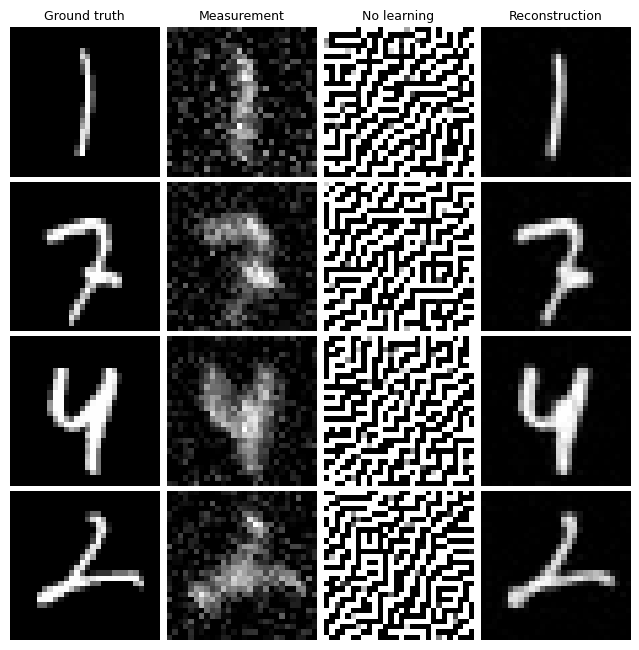

Test: 100%|████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s, PSNR=23.1, PSNR no learning=-22.3, SSIM=0.88, SSIM no learning=0.000439]

Test results:
PSNR no learning: -22.339 +- 0.415
PSNR: 23.088 +- 2.332
SSIM no learning: 0.000 +- 0.001
SSIM: 0.880 +- 0.028


{'PSNR no learning': np.float64(-22.33907958984375),
 'PSNR no learning_std': np.float64(0.4145493982946885),
 'PSNR': np.float64(23.08832763671875),
 'PSNR_std': np.float64(2.3320009652719342),
 'SSIM no learning': np.float64(0.0004387101158499718),
 'SSIM no learning_std': np.float64(0.0005747215331321766),
 'SSIM': np.float64(0.8797159576416016),
 'SSIM_std': np.float64(0.028251860309618418)}

In [ ]:
#TEST
dinv.training.test(model=modelUnr,
    test_dataloader=test_dataloader,
    physics=blur_physics,
    device=device,
    metrics = [dinv.loss.metric.PSNR(), dinv.loss.metric.SSIM()],
    plot_images=True,
    verbose=True,
)